#The Final Submission Model

##Import the necessary **libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GlobalMaxPooling1D, Dense
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import seaborn as sns

##Import Train and test datasets

In [4]:
!git clone https://github.com/bourasmohamedyoucefenssea/Natural-Language-Processing.git
%cd Natural-Language-Processing
df = pd.read_csv('Deep Learning/train.csv.zip')
test_df = pd.read_csv('Deep Learning/test.csv.zip')
class_distribution = df['state'].value_counts()
print(class_distribution)
print(df.isnull().sum())

Cloning into 'Natural-Language-Processing'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (15/15), 18.71 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/Natural-Language-Processing/Natural-Language-Processing/Natural-Language-Processing
0    105860
1     96482
Name: state, dtype: int64
blurb         3
state         0
created_at    0
id            0
dtype: int64


##Exploratory Data Analysis


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202342 entries, 0 to 202341
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   blurb       202342 non-null  object
 1   state       202342 non-null  int64 
 2   created_at  202342 non-null  object
 3   id          202342 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.2+ MB
None


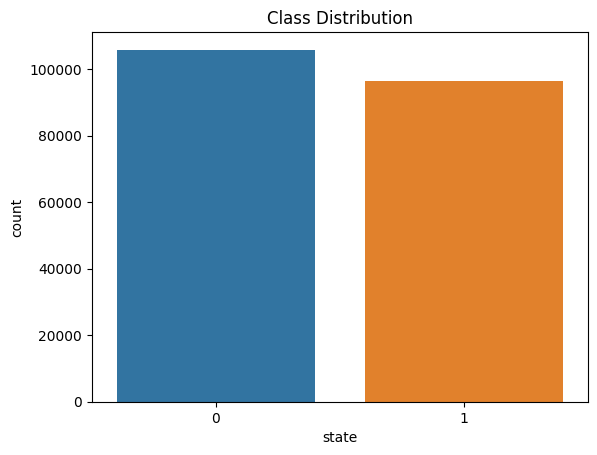

In [ ]:
sns.countplot(x='state', data=df)
plt.title('Class Distribution')
plt.show()

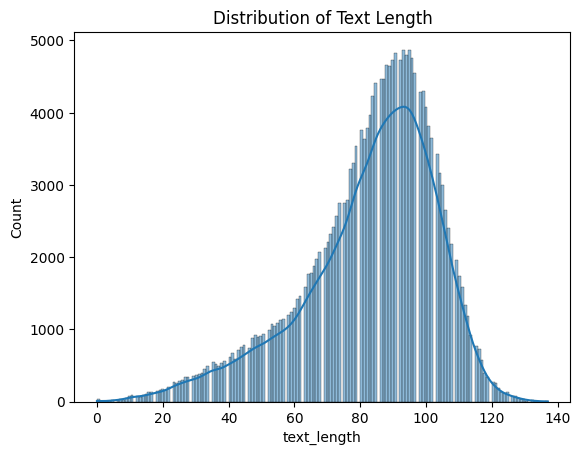

In [ ]:
# Text Length Distribution
df['text_length'] = df['blurb'].apply(len)
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Length')
plt.show()

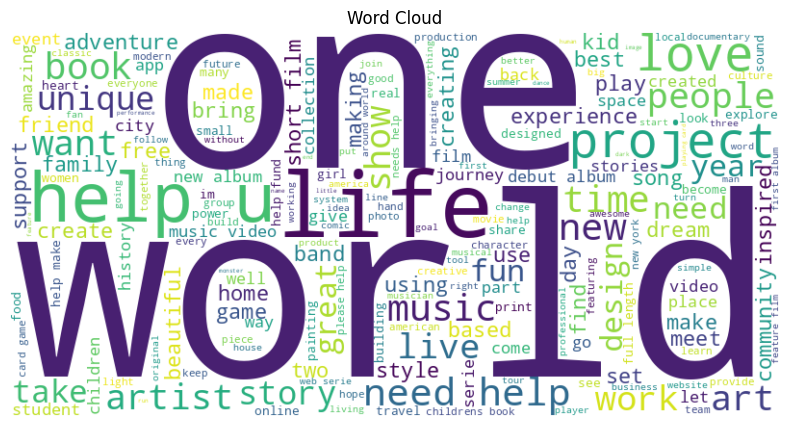

In [ ]:
from wordcloud import WordCloud
all_text = ' '.join(df['blurb'])
wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

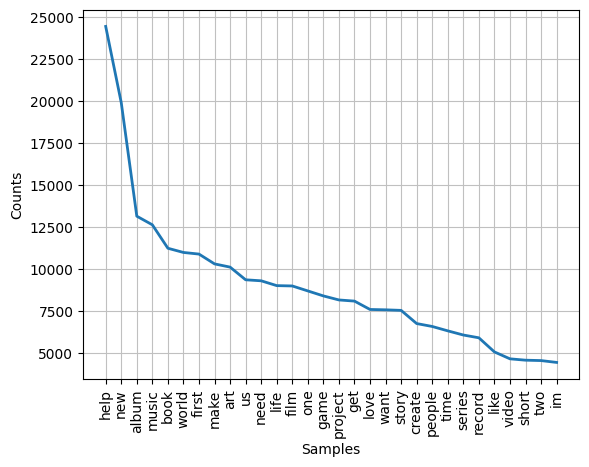

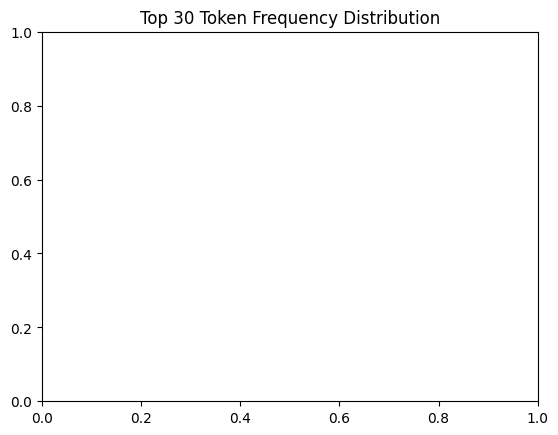

In [ ]:
import nltk
import string
from nltk.probability import FreqDist
nltk.download('punkt')
from nltk.tokenize import word_tokenize
tokens = word_tokenize(all_text)
tokens = [word.lower() for word in tokens if word.isalpha() and word not in string.punctuation]
fdist = FreqDist(tokens)
fdist.plot(30, cumulative=False)
plt.title('Top 30 Token Frequency Distribution')
plt.show()

## Cleaning and Preprocessing

In [ ]:
def preprocess_with_tokenization(df, text_column, label_column, test_size=0.001, random_state=42):
    # Fill NaN values with the mode of the 'blurb' column
    mode_value = df[text_column].mode().iloc[0]
    df[text_column].fillna(mode_value, inplace=True)
    df[text_column] = df[text_column].str.lower()
    df[text_column] = df[text_column].str.replace('[^a-zA-Z\s]', '')
    # Remove stopwords
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    df[text_column] = df[text_column].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    # Tokenization
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df[text_column])
    X_seq = tokenizer.texts_to_sequences(df[text_column])
    max_len = max(len(seq) for seq in X_seq)
    X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post')
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_padded, df[label_column], test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val, tokenizer, max_len
X_train, X_val, y_train, y_val, tokenizer, max_len = preprocess_with_tokenization(df, 'blurb', 'state')

<ipython-input-3-5bfb7f74e66f>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_column] = df[text_column].str.replace('[^a-zA-Z\s]', '')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Neural Network Archetucture

In [ ]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout, BatchNormalization
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=1000, input_length=max_len))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Bidirectional(GRU(200, return_sequences=True)))  # I have try to fit GRU instead of LSTM because of time running.
model2.add(GlobalMaxPooling1D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=512)
# AUC Score: 0.9250183314898464 for now this is the best model, batch 128, epoch 20, test: 0.1
# AUC Score: 0.9246690137339518 : i've changed the epochs number to 40: and there is no improvement in the AUC score
# AUC Score: 0.9251230549073175 : the best batch for this model is 128, using the new preprocessing function
# AUC Score: 0.9234646357315675: this time i tried to remove the step of stopword and there is an improvement in the model
# AUC Score: 0.9303605752013134:  THIS IS THE best ACCURACY WITH ALL THE PREPROCESSING STEPS AND WITH A TESTING SPLIT OF 0.08.
# AUC Score: 0.931146983275903 THIS IS THE best ACCURACY WITH TESTING DATA OF 0.01.
# AUC Score: 0.9677387914230019 Decreazse the number of units in the cnn layer, there is no improvement
# AUC Score: 0.959307992202729 GRU instead of bidirection GRU: no improvement
# submission 60: this is the last try: batch size 256, training set: 0.001, epochs 10, filling Na's with the mode, same archetucture, output_dim =1000,

Epoch 1/15
395/395 [==============================] - 58s 117ms/step - loss: 0.5416 - accuracy: 0.7188 - val_loss: 0.4154 - val_accuracy: 0.7980
Epoch 2/15
395/395 [==============================] - 24s 60ms/step - loss: 0.1922 - accuracy: 0.9271 - val_loss: 0.2461 - val_accuracy: 0.9064
Epoch 3/15
395/395 [==============================] - 19s 49ms/step - loss: 0.0520 - accuracy: 0.9835 - val_loss: 0.3517 - val_accuracy: 0.9212
Epoch 4/15
395/395 [==============================] - 19s 47ms/step - loss: 0.0305 - accuracy: 0.9891 - val_loss: 0.4334 - val_accuracy: 0.8867
Epoch 5/15
395/395 [==============================] - 18s 46ms/step - loss: 0.0265 - accuracy: 0.9901 - val_loss: 0.4175 - val_accuracy: 0.8768
Epoch 6/15
395/395 [==============================] - 22s 55ms/step - loss: 0.0246 - accuracy: 0.9905 - val_loss: 0.4627 - val_accuracy: 0.8966
Epoch 7/15
395/395 [==============================] - 19s 48ms/step - loss: 0.0208 - accuracy: 0.9921 - val_loss: 0.4990 - val_accuracy

##Model Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred = model2.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred)
print(f'AUC Score: {auc_score}')

7/7 [==============================] - 1s 26ms/step
AUC Score: 0.9537037037037036


##Submission

In [ ]:
def preprocess_test_with_tokenization(test_df, tokenizer, max_len, text_column):
    test_df[text_column].fillna(' ', inplace=True)
    test_df[text_column] = test_df[text_column].str.lower()
    test_df[text_column] = test_df[text_column].str.replace('[^a-zA-Z\s]', '')
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    test_df[text_column] = test_df[text_column].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    test_seq = tokenizer.texts_to_sequences(test_df[text_column])
    test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post')
    return test_padded
X_test_tokenization = preprocess_test_with_tokenization(test_df, tokenizer, max_len, 'blurb')
test_predictions = model2.predict(X_test_tokenization)
submission_df = pd.DataFrame({'id': test_df['id'], 'state': test_predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)

<ipython-input-51-a103a9741f83>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df[text_column] = test_df[text_column].str.replace('[^a-zA-Z\s]', '')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2108/2108 [==============================] - 6s 3ms/step


#Different Neural Network Archtectures
in this section i mention all the models that I've used in this competition

##LSTM

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)
# AUC Score: 0.920959839234683 deal with stop words: batch 32,
# AUC Score: 0.9239962508938275 Remove stop words:
# AUC Score: 0.9211176336702849 the new preprocessing function
from sklearn.metrics import roc_auc_score
y_pred = model.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred)
print(f'AUC Score: {auc_score}')
test_df['blurb'].fillna('', inplace=True)
test_df['blurb'] = test_df['blurb'].str.lower()
test_df['blurb'] = test_df['blurb'].str.replace('[^a-zA-Z\s]', '')
test_seq = tokenizer.texts_to_sequences(test_df['blurb'])
test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_predictions = model.predict(test_padded)
submission_df = pd.DataFrame({'id': test_df['id'], 'state': test_predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)

##LSTM With batchnormalization


In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
model1 = Sequential()
model1.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
model1.add(Conv1D(128, 5, activation='relu'))
model1.add(MaxPooling1D(5))
model1.add(Bidirectional(LSTM(100, return_sequences=True)))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))  # Add dropout for regularization
model1.add(BatchNormalization())  # Add batch normalization
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)
# AUC Score: 0.9193359120626976: 0.92236 kaggle
# AUC Score: 0.9258852787834425: 0.92513 kaggle
# AUC Score: 0.918287797365979 with stopwords
from sklearn.metrics import roc_auc_score
y_pred = model1.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred)
print(f'AUC Score: {auc_score}')
test_df['blurb'].fillna('', inplace=True)
test_df['blurb'] = test_df['blurb'].str.lower()
test_df['blurb'] = test_df['blurb'].str.replace('[^a-zA-Z\s]', '')
test_seq = tokenizer.texts_to_sequences(test_df['blurb'])
test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_predictions = model1.predict(test_padded)
submission_df = pd.DataFrame({'id': test_df['id'], 'state': test_predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)

##GRU

In [ ]:
from tensorflow.keras.layers import GRU
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Bidirectional(GRU(100, return_sequences=True)))  # I have try to fit GRU instead of LSTM because of time running.
model2.add(GlobalMaxPooling1D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)
# AUC Score: 0.9250183314898464 for now this is the best model, batch 128, epoch 20, test: 0.1
# AUC Score: 0.9246690137339518 : i've changed the epoch number to 40: and there is no improvement in the AUC score
# AUC Score: 0.9251230549073175 : the best batch for this model is 128 and using the new preprocessing function
# AUC Score: 0.9234646357315675: this time i tried to remove the step of stopword and there is an improvement in the model
from sklearn.metrics import roc_auc_score
y_pred = model2.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred)
print(f'AUC Score: {auc_score}')
test_df['blurb'].fillna('', inplace=True)
test_df['blurb'] = test_df['blurb'].str.lower()
test_df['blurb'] = test_df['blurb'].str.replace('[^a-zA-Z\s]', '')
test_seq = tokenizer.texts_to_sequences(test_df['blurb'])
test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_predictions = model2.predict(test_padded)
submission_df = pd.DataFrame({'id': test_df['id'], 'state': test_predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)

##GRU with hyperparameter Tuning

In [ ]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import GRU

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
    model.add(Conv1D(hp.Int('conv_units', min_value=32, max_value=256, step=32), 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Bidirectional(GRU(hp.Int('gru_units', min_value=32, max_value=256, step=32), return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # adjust as needed
    directory='tuner_logs',
    project_name='gru_tuning'
)
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=128)
best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print("Best Hyperparameters:", best_hp)
best_model = tuner.get_best_models(num_models=1)[0]
y_pred_val = best_model.predict(X_val)
auc_val = roc_auc_score(y_val, y_pred_val)
print(f'AUC on Validation Set: {auc_val}')
test_df['blurb'].fillna('', inplace=True)
test_df['blurb'] = test_df['blurb'].str.lower()
test_df['blurb'] = test_df['blurb'].str.replace('[^a-zA-Z\s]', '')
test_seq_test = tokenizer.texts_to_sequences(test_df['blurb'])
test_padded_test = pad_sequences(test_seq_test, maxlen=max_len, padding='post')
test_predictions = best_model.predict(test_padded_test)
submission_df = pd.DataFrame({'id': test_df['id'], 'state': test_predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)

##RNN

In [ ]:
from tensorflow.keras.layers import SimpleRNN
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
model_rnn.add(Conv1D(128, 5, activation='relu'))
model_rnn.add(MaxPooling1D(5))
model_rnn.add(Bidirectional(SimpleRNN(100, return_sequences=True)))
model_rnn.add(GlobalMaxPooling1D())
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(BatchNormalization())
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)
# AUC Score: 0.9231999214652638 0.92565
from sklearn.metrics import roc_auc_score
y_pred = model_rnn.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred)
print(f'AUC Score: {auc_score}')
test_df['blurb'].fillna('', inplace=True)
test_df['blurb'] = test_df['blurb'].str.lower()
test_df['blurb'] = test_df['blurb'].str.replace('[^a-zA-Z\s]', '')
test_seq = tokenizer.texts_to_sequences(test_df['blurb'])
test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_predictions = model_rnn.predict(test_padded)
submission_df = pd.DataFrame({'id': test_df['id'], 'state': test_predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)